In [1]:
import sqlite3
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
db = sqlite3.connect('./coupons.db')

In [3]:
df_merchants = pd.read_sql('select * from merchant', db)
df_merchants.head(5)

,id,name
0,1,Barker-Wong
1,2,Ryan-Mathews
2,3,"Hansen, Hess and Walsh"
3,4,West-Hudson
4,5,Thompson Ltd


In [4]:
df_customers = pd.read_sql('select * from customer', db)
df_customers.head(5)

,id,name
0,1,Erica Thomas
1,2,Joshua Garcia
2,3,Susan Burton
3,4,Daniel Price
4,5,Marie Obrien


In [5]:
df_coupons = pd.read_sql('select * from coupon', db)
df_coupons.head(5)

,id,name,discount
0,1,RRQBLRWP,9.5
1,2,LZXEVGUC,2.5
2,3,EOTJALWS,2.0
3,4,PYHSAUUA,6.5
4,5,SUUCDNWE,5.0


In [6]:
df_sales = pd.read_sql('select * from sale', db, parse_dates = ['ts'])
df_sales.head(5)

,id,merchant_id,customer_id,coupon_id,bill_amount,ts
0,1,75,292,80,3300,2017-12-20 07:22:32
1,2,93,1094,21,600,2017-04-24 11:40:38
2,3,143,813,324,2300,2019-03-01 15:04:10
3,4,132,9,84,300,2017-08-08 15:40:33
4,5,12,115,33,1000,2017-12-07 16:28:14


In [7]:
db.close()

In [8]:
# df_sales = df_sales.set_index('ts')

In [9]:
df_sales['discount_percent'] = df_sales['coupon_id'].apply(lambda x: float(df_coupons[df_coupons['id'] == x]['discount']))
df_sales['discount'] = (df_sales['bill_amount'] * df_sales['discount_percent'])/100
df_sales['discount'] = df_sales['discount'].map(lambda x: x if x<300.0 else 300.0)
df_sales['discounted_amount'] = df_sales['bill_amount'] - df_sales['discount']

In [10]:
df_sales['month_of_sale'] = df_sales['ts'].apply(lambda x: x.month)

In [11]:
df_sales.head(5)

,id,merchant_id,customer_id,coupon_id,bill_amount,ts,discount_percent,discount,discounted_amount,month_of_sale
0,1,75,292,80,3300,2017-12-20 07:22:32,5.5,181.5,3118.5,12
1,2,93,1094,21,600,2017-04-24 11:40:38,2.0,12.0,588.0,4
2,3,143,813,324,2300,2019-03-01 15:04:10,5.0,115.0,2185.0,3
3,4,132,9,84,300,2017-08-08 15:40:33,1.0,3.0,297.0,8
4,5,12,115,33,1000,2017-12-07 16:28:14,6.5,65.0,935.0,12


## Top 10 customers who spent maximum amount (consider discounted price) in month of March.

In [12]:
top_10_cust_march = df_sales[df_sales['month_of_sale'] == 3][['customer_id','discounted_amount']].groupby('customer_id').sum().sort_values('discounted_amount', ascending = False).head(10)
top_10_cust_march = top_10_cust_march.reset_index()

In [13]:
top_10_cust_march['customer_name'] = top_10_cust_march['customer_id'].apply(lambda x: list(df_customers[df_customers['id'] == x]['name'])[0])

In [14]:
top_10_cust_march

,customer_id,discounted_amount,customer_name
0,1420,12531.5,Brianna Morales
1,643,11932.5,Jeffery Valenzuela
2,471,11471.0,Craig Patterson
3,165,10960.0,Mark Sharp
4,1190,10089.0,Jennifer Alvarado
5,634,9611.5,Matthew Guerrero
6,575,9361.0,Peter Taylor
7,598,9339.5,Eric Green
8,1078,9286.5,Lisa Miller
9,1227,9264.5,Michael Davis


## Top 20 merchants with maximum turnover (complete data) on the e-commerce platform

In [15]:
top_20_merch = df_sales[['merchant_id','bill_amount']].groupby('merchant_id').sum().sort_values('bill_amount', ascending = False).head(20)
top_20_merch = top_20_merch.reset_index()

In [16]:
top_20_merch['merchant_name'] = top_20_merch['merchant_id'].apply(lambda x: list(df_merchants[df_merchants['id'] == x]['name'])[0])

In [17]:
top_20_merch

,merchant_id,bill_amount,merchant_name
0,101,194400,"Ford, Davidson and Snyder"
1,187,182500,Patrick-Ray
2,159,179400,Marquez Inc
3,113,170300,Mcpherson Group
4,123,169300,Griffin-Duran
5,35,165700,Martin Group
6,54,164200,Rose-Peterson
7,182,162600,"Coleman, Cohen and Gutierrez"
8,49,162500,Williams-Petersen
9,58,161200,"Hooper, Cole and Callahan"


### Top 10 coupons with maximum utilization

In [18]:
df_sales[['id','coupon_id']].groupby('coupon_id').count().sort_values('id', ascending = False).head(10)

,id
coupon_id,
199,47
42,42
395,40
37,40
400,37
399,37
316,36
5,35
272,35


## Top 3 coupons which were utilized in each month

In [19]:
top_coupons = pd.DataFrame()

In [20]:
for i in range(1,13):
    top_coupons[str(i)] = list(df_sales[df_sales['month_of_sale'] == i][['coupon_id','month_of_sale']].groupby('coupon_id').count().sort_values('month_of_sale', ascending = False).head(3).reset_index()['coupon_id'])

In [21]:
top_coupons

,1,2,3,4,5,6,7,8,9,10,11,12
0,210,338,373,67,272,398,253,239,377,213,30,169
1,316,228,257,130,116,395,316,137,375,276,248,76
2,199,217,383,216,17,103,117,222,334,73,399,82


## Top 50 coupons for which e-commerce platform gave discount in terms of money spent.

In [22]:
df_sales[['coupon_id','discount']].groupby('coupon_id').sum().sort_values('discount', ascending = False).head(50)

,discount
coupon_id,
199,7867.0
383,7020.0
235,6966.0
112,6684.0
58,6627.0
372,6592.0
207,6587.0
395,6509.5
90,6452.5


## Plot graph for number of coupons used in each month

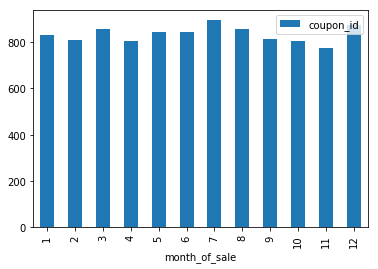

In [23]:
df_sales[['coupon_id','month_of_sale']].groupby('month_of_sale').count().plot(kind = 'bar')